# Integrating HWM93 with STK using Python

STK integration with Python opens up a lot of possibilites for working with numerous open science models. 

This script shows an example of incorporating the Horizontal Wind Model 93 (https://ccmc.gsfc.nasa.gov/modelweb/atmos/hwm.html) into STK scenarios. HWM93 is a popular empirical wind model based on satellite and ground-based instrument data. This model is available as Fortran 77 code which can be built in Python using f2py and a fortran compiler (https://github.com/space-physics/hwm93). 

To import the external wind model, you can clone the repo, and use sys.path.append('FILEPATH') to add the cloned repo to the path. You can then import the model. To install a fortran compiler in an anaconda environment, you can run the following command in the anaconda prompt:<br>
<code>conda install -c conda-forge flang</code>

Two example use-cases with the wind model are shown here:
1. HWM93 is used to compute wind components encountered by a Missile object and the data is passed to STK for reporting.
2. A high altitude balloon is simulated by integrating wind speed at each timestep (Just a simple distance = speed x time is done here for demo. Trapezoidal integration or Runge-Kutta higher order methods can be employed if needed)

In [1]:
# Just check python version and make sure it is not 3.7.6 or 3.8.1
from platform import python_version

print(python_version())

3.8.3


#### Import the required libraries:

In [2]:
# Import STK Python API
from agi.stk12.stkdesktop import STKDesktop
from agi.stk12.stkobjects import *

import numpy as np
import os
import math
from datetime import datetime

In [3]:
# add the installed hwm93 library to path and then import
import sys

sys.path.append("C:{FILEPATH}/hwm93/")  # Add the external wind model to the path
import hwm93  # Import the wind model

#### Create STK instance:

In [4]:
stk = STKDesktop.StartApplication(visible=True)  # using optional visible argument
# stkapp.Visible = True
# stkapp.UserControl = True

In [5]:
root = stk.Root
# from comtypes.gen import STKObjects, STKUtil #These libraries can't be imported before running stkapp.Personality2

Create new scenario and get reference to it:

In [6]:
root.NewScenario("HWM93STKPy")  # Do not have spaces in scenario name
scenario = root.CurrentScenario

Set scenario start and stop times:

In [7]:
scenario.StartTime = "10 Dec 2020 15:00:00.000"
scenario.StopTime = "11 Dec 2020 15:00:00.000"
root.Rewind();  # reset to the new start time"

## Example 1: Winds encountered by a Missile

In [8]:
# Define a missile using launch, impact coordinates and apogee altitude method

missile = scenario.Children.New(13, "MyMissile")  # eMissile


missile.SetTrajectoryType(10)  # ePropagatorBallistic
trajectory = missile.Trajectory


launchLLA = trajectory.Launch
launchLLA.Lat = 10
launchLLA.Lon = 10

impactLocation = trajectory.ImpactLocation
ImpactLLA = impactLocation.Impact
ImpactLLA.Lat = 0
ImpactLLA.Lon = 0

impactLocation.SetLaunchControlType(0)  # eLaunchControlFixedApogeeAlt
launchControl = impactLocation.LaunchControl
launchControl.ApogeeAlt = 200  # km

trajectory.Propagate()

In [9]:
# Get LLA data for the propagated missile

LLAdata = missile.DataProviders.GetDataPrvTimeVarFromPath("LLA State/Fixed")
elements = ["Time", "Lat", "Lon", "Alt"]  # only need time and LLA
results = LLAdata.ExecElements(
    scenario.StartTime, scenario.StopTime, 1, elements
)  # scenario times in EpSec for convenience, obtained at 1 sec cadence

root.UnitPreferences.SetCurrentUnit("DateFormat", "UTCG")
# back to UTCG since HWM93 needs it
missile_t = results.DataSets.GetDataSetByName("Time").GetValues()
missile_lats = results.DataSets.GetDataSetByName("Lat").GetValues()
missile_lons = results.DataSets.GetDataSetByName("Lon").GetValues()
missile_alts = results.DataSets.GetDataSetByName("Alt").GetValues()  # in km

In [10]:
# Use the HWM93 wind model to obtain wind at different points along the trajectory

missile_u = np.zeros(np.shape(missile_lats))  # init
missile_v = np.zeros(np.shape(missile_lats))
for k in range(len(missile_lats)):
    trajWind = hwm93.run(
        time=missile_t[k],
        altkm=missile_alts[k],
        glat=missile_lats[k],
        glon=missile_lons[k],
        f107a=150,
        f107=150,
        ap=4,
    )
    missile_u[k] = trajWind.zonal.values[0]
    missile_v[k] = trajWind.meridional.values[0]
    k += 1

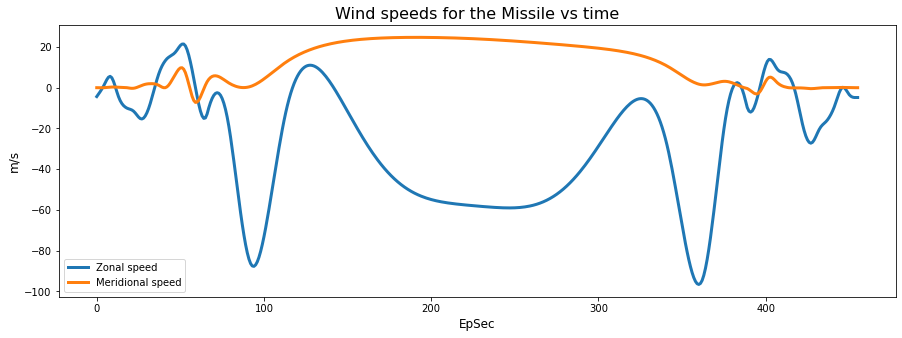

In [11]:
# Create a line plot to visualize wind speeds
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 5)
plt.plot(missile_u, linewidth=3.0, label="Zonal speed")
plt.plot(missile_v, linewidth=3.0, label="Meridional speed")
plt.ylabel("m/s", fontsize=12)
plt.xlabel("EpSec", fontsize=12)
plt.legend()
plt.title("Wind speeds for the Missile vs time", fontsize=16);

#### Writing missile LLA and wind data to an STK-readable text file:

In [12]:
# Writing block of data to be written in the file
root.UnitPreferences.SetCurrentUnit("DateFormat", "EpSec")
# back to EpSec for writing to external file
missile_t_EpSec = results.DataSets.GetDataSetByName("Time").GetValues()
DataToWrite = ""
for k in range(len(missile_lats)):
    line = "%.14e %f %f %f %f %f" % (
        missile_t_EpSec[k],
        missile_lats[k],
        missile_lons[k],
        missile_alts[k],
        missile_u[k],
        missile_v[k],
    )
    DataToWrite += line
    DataToWrite += "\n"

In [13]:
# Formatting data to write as STK-readable text file
ToWrite = """stk.v.12.1 \n
\n
Begin DataGroup\n
GroupName\t Missile Trajetory and Wind
NumberOfPoints\t %d
BlockFactor\t 50
ReferenceEpoch\t %s \n
Begin DataElement
Name\t Lat
Dimension\t Lat
FileUnitAbbr\t deg
InterpOrder\t 1
End DataElement
\n
Begin DataElement
Name\t Lon
Dimension\t Lon
FileUnitAbbr\t deg
InterpOrder\t 1
End DataElement
\n
Begin DataElement
Name\t Alt
Dimension\t DistanceUnit
FileUnitAbbr\t km
InterpOrder\t 1
End DataElement
\n
Begin DataElement
Name\t Zonal Wind
Dimension\t Rate
FileUnitAbbr\t m
FileUnitAbbr\t sec
InterpOrder\t 1
End DataElement
\n
Begin DataElement
Name\t Meridional Wind
Dimension\t Rate
FileUnitAbbr\t m
FileUnitAbbr\t sec
InterpOrder\t 1
End DataElement

Begin Data\n
%s
End Data
""" % (
    len(missile_lats),
    missile_t[0],
    DataToWrite,
)

In [14]:
# Save the formatted data as a text file
MissileDataFile = open(r"C:\Users\nstankey\Documents\STK 12\MissileWindData.txt", "w")
MissileDataFile.write(ToWrite)
MissileDataFile.close()

In [15]:
# Send connect command to send the file as User Defined data (either here or from GUI)
root.ExecuteCommand(
    'ExternalData */Missile/MyMissile ReadFile "C:/Users/{FILEPATH}/Documents/STK 12/MissileWindData.txt" Save'
)

## Example 2: Simulating a high altitude balloon

#### Create the balloon:

Insert an aircraft object that will be our balloon:

In [16]:
aircraft = scenario.Children.New(AgESTKObjectType.eAircraft, "TestBalloon")

Set Propagator to GreatArc:

In [17]:
aircraft.SetRouteType(AgEVePropagatorType.ePropagatorGreatArc)
route = aircraft.Route

#### User inputs here:

In [18]:
deltaT = 30  # timestep for distance calculation in seconds
alt = 30000  # meters, alt will not be varied in this example
FirstWayPt = np.array([50, -20])  # starting lat,lon of the balloon
Rearth = 6371000  # Earth's radius in m

# space environment parameters
Setf107a = 150
Setf107 = 150
Setap = 4

#### Computations:

Setting the units:
(Setting date format to Epoch sec saves the trouble of handling UTCG time strings)

In [19]:
root.UnitPreferences.SetCurrentUnit("DistanceUnit", "m"),
root.UnitPreferences.SetCurrentUnit("DateFormat", "EpSec");

Initialize arrays to hold timestep and waypoint data:

In [20]:
timesteps = np.arange(
    start=scenario.StartTime, stop=scenario.StopTime, step=deltaT
)  # create array of timesteps(size:N)
waypoints = np.zeros(
    [np.size(timesteps), 4]
)  # init array for storing waypoints (size: Nx4 for lat, lon, alt and time)

Function definition to compute LatLon from distance traversed by the balloon:

In [21]:
def Distance2LatLon(Lat1, Lon1, zonal_dist, meridional_dist, Rearth):

    """Function to compute updated lat lon based on zonal and meridional distance traverse.d
    Uses approximate inverse Haversine formula for sphere (good enough!)
    Inputs: Initial coordinates (Lat1, Lon1) in degrees; zonal, meridional distances travelled and Rearth in meters
    Outputs: Update coordinates (Lat2, Lon2)"""

    # prep values
    dlat = MDist / Rearth
    dlon = ZDist / Rearth
    lat1 = math.radians(Lat1)  # convert to radians
    lon1 = math.radians(Lon1)

    # compute new lat, lon based on approx. inverse Haversine formula
    lat2 = math.asin(math.sin(lat1) * math.cos(dlat) + math.cos(lat1) * math.sin(dlat))
    lon2 = lon1 + math.atan2(
        math.sin(dlon) * math.cos(lat1),
        math.cos(dlon) - math.sin(lat1) * math.sin(lat2),
    )

    # convert back to degrees
    Lat2 = math.degrees(lat2)
    Lon2 = math.degrees(lon2)

    return Lat2, Lon2

Compute balloon waypoints:

In [22]:
for i in range(0, len(waypoints)):
    if i == 0:
        # Assign values for the first waypoint
        waypoints[i, 0] = FirstWayPt[0]  # starting lat
        waypoints[i, 1] = FirstWayPt[1]  # starting lon
        waypoints[i, 2] = alt
        waypoints[i, 3] = scenario.StartTime
    else:  # for all waypoints except the first

        # Get the wind info (returned as an xarray structure in m/s)
        # HWM93 wind model requires time input as py datetime object
        PrevTime = root.ConversionUtility.ConvertDate(
            "EpSec", "UTCG", str(waypoints[i - 1, 3])
        )  # step1. Get UTCG string
        PrevTimeObj = datetime.strptime(
            PrevTime, "%d %b %Y %H:%M:%S.%f"
        )  # step2.  convert to py datetime obj

        # computing wind at previous way point
        wind = hwm93.run(
            time=PrevTimeObj,
            altkm=alt / 1000,
            glat=waypoints[i - 1, 0],
            glon=waypoints[i - 1, 1],
            f107a=Setf107a,
            f107=Setf107,
            ap=Setap,
        )

        # Calculate distance traversed in deltaT time
        ZDist = (
            deltaT * wind.zonal.values[0]
        )  # zonal distance traversed in deltaT time (in meters)
        MDist = (
            deltaT * wind.meridional.values[0]
        )  # meridional distance traversed in deltaT time (in meters)

        # Calculate next waypoint coordinates
        newLat, newLon = Distance2LatLon(
            waypoints[i - 1, 0], waypoints[i - 1, 1], ZDist, MDist, Rearth
        )

        waypoints[i, 0] = newLat  # in degrees
        waypoints[i, 1] = newLon  # in degrees
        waypoints[i, 2] = alt  # in meters
        waypoints[i, 3] = timesteps[i]  # in Epoch seconds

#### Feeding the computed waypoints to STK:

We will use eDetermineVelFromTime calculation method since we have coordinates and timesteps defined

In [23]:
# Set Calculation method and altitude reference
route.Method = AgEVeWayPtCompMethod.eDetermineVelFromTime
route.SetAltitudeRefType(AgEVeAltitudeRef.eWayPtAltRefMSL);

Very important to clear any previous waypoints:

In [24]:
# remove any previous waypoints
route.Waypoints.RemoveAll();

In [25]:
int(waypoints[0, 0])

50

In [26]:
for count in range(0, len(waypoints)):
    point = route.Waypoints.Add()
    point.Latitude = float(waypoints[count, 0])
    point.Longitude = float(waypoints[count, 1])
    point.Altitude = float(waypoints[count, 2])
    point.Time = float(waypoints[count, 3])

Finally, propagate the route:

In [27]:
route.Propagate();

Change to a Balloon 3D model, if available:

In [28]:
# modelfile = aircraft2.VO.Model.ModelData.QueryInterface(STKObjects.IAgVOModelFile)
# modelfile.Filename = os.path.abspath(stkapp.Path[:-3] + "STKData\\VO\\Models\\Misc\\bomb.mdl")

#### Visualizing wind field in Python
To visualize the wind field generated by the model, we can specify a geographical grid, altitude and time.

In [29]:
# Set the grographical coverage
lats = np.arange(-90.0, 90.0, 5.0)
lons = np.arange(-180.0, 180.0, 15.0)
LAT, LON = np.meshgrid(lats, lons)
altinkm = 30
Setf107a = 150
Setf107 = 150
Setap = 4

In [30]:
# Set the query time
from datetime import datetime

QueryTime = "10 Dec 2020 15:00:00.000"
QueryTimeObj = datetime.strptime(QueryTime, "%d %b %Y %H:%M:%S.%f")

In [31]:
U = np.zeros(np.shape(LAT))
V = np.zeros(np.shape(LAT))
for j in range(len(lats)):
    for i in range(len(lons)):
        thisWind = hwm93.run(
            time=QueryTimeObj,
            altkm=altinkm,
            glat=lats[j],
            glon=lons[i],
            f107a=Setf107a,
            f107=Setf107,
            ap=Setap,
        )
        U[i, j] = thisWind.zonal.values[0]
        V[i, j] = thisWind.meridional.values[0]
        i += 1
    j += 1

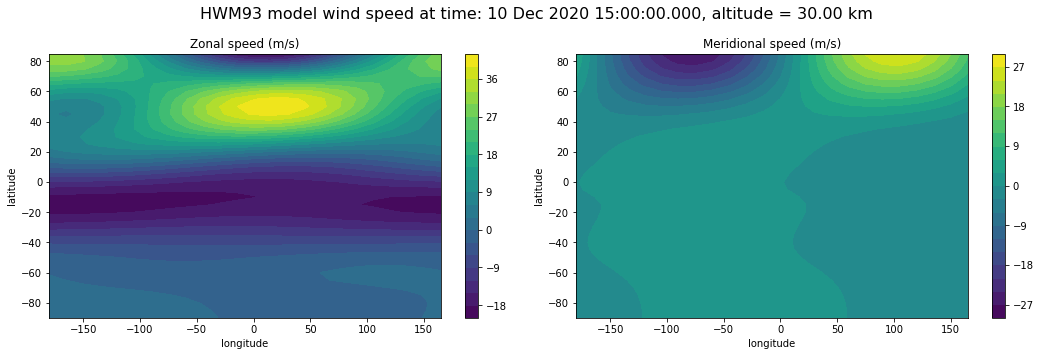

In [36]:
# plotting
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2)  # get handles for fig and axes (subplots)
plt.rcParams["figure.figsize"] = (15, 5)

# generate first subplot
cntr = ax[0].contourf(lons, lats, np.transpose(U), levels=20)
fig.colorbar(cntr, ax=ax[0])
ax[0].set_title("Zonal speed (m/s)")
ax[0].set_xlabel("longitude")
ax[0].set_ylabel("latitude")
# generate second subplot (using a more concise method)
cntr2 = ax[1].contourf(lons, lats, np.transpose(V), levels=20)
fig.colorbar(cntr2, ax=ax[1])
ax[1].set(title="Meridional speed (m/s)", xlabel="longitude", ylabel="latitude")

# overall attributes
plt.suptitle(
    "HWM93 model wind speed at time: %s, altitude = %.2f km" % (QueryTime, altinkm),
    fontsize=16,
)  # super title
plt.tight_layout()  # ensures no overlap of subplots
plt.subplots_adjust(top=0.85)

Balloon speed can be imported into STK using the same method as in Example 1.